In [25]:
%%capture
%run final_chars_classification.ipynb



In [26]:
%run table_detector.ipynb

In [27]:
%run final_functions.ipynb

In [28]:
%run preprocessing.ipynb

In [29]:
%run get_rows_number.ipynb

In [30]:
class McCluskey:
    mt=[]
    dc=[]

    def mul(self,x,y): # Multiply 2 minterms
        res = []
        for i in x:
            if i+"'" in y or (len(i)==2 and i[0] in y):
                return []
            else:
                res.append(i)
        for i in y:
            if i not in res:
                res.append(i)
        return res

    def multiply(self,x,y): # Multiply 2 expressions
        res = []
        for i in x:
            for j in y:
                tmp = self.mul(i,j)
                res.append(tmp) if len(tmp) != 0 else None
        return res

    def refine(self,my_list,dc_list): # Removes don't care terms from a given list and returns refined list
        res = []
        for i in my_list:
            if int(i) not in dc_list:
                res.append(i)
        return res

    def findEPI(self,x): # Function to find essential prime implicants from prime implicants chart
        res = []
        for i in x:
            if len(x[i]) == 1:
                res.append(x[i][0]) if x[i][0] not in res else None
        return res

    def findVariables(self,x): # Function to find variables in a minterm. For example, the minterm --01 has C' and D as variables
        var_list = []
        for i in range(len(x)):
            if x[i] == '0':
                var_list.append(chr(i+65)+"'")
            elif x[i] == '1':
                var_list.append(chr(i+65))
        return var_list

    def flatten(self,x): # Flattens a list
        flattened_items = []
        for i in x:
            flattened_items.extend(x[i])
        return flattened_items

    def findminterms(self,a): #Function for finding out which minterms are merged. For example, 10-1 is obtained by merging 9(1001) and 11(1011)
        gaps = a.count('-')
        if gaps == 0:
            return [str(int(a,2))]
        x = [bin(i)[2:].zfill(gaps) for i in range(pow(2,gaps))]
        temp = []
        for i in range(pow(2,gaps)):
            temp2,ind = a[:],-1
            for j in x[0]:
                if ind != -1:
                    ind = ind+temp2[ind+1:].find('-')+1
                else:
                    ind = temp2[ind+1:].find('-')
                temp2 = temp2[:ind]+j+temp2[ind+1:]
            temp.append(str(int(temp2,2)))
            x.pop(0)
        return temp

    def compare(self,a,b): # Function for checking if 2 minterms differ by 1 bit only
        c = 0
        for i in range(len(a)):
            if a[i] != b[i]:
                mismatch_index = i
                c += 1
                if c>1:
                    return (False,None)
        return (True,mismatch_index)

    def removeTerms(self,_chart,terms): # Removes minterms which are already covered from chart
        for i in terms:
            for j in self.findminterms(i):
                try:
                    del _chart[j]
                except KeyError:
                    pass

    def solve(self,cells,num_col):
        print('COLS' + str(num_col) )
        
        print(cells)            
        i = num_col-1
        mt = 0
        while i < len(cells):
            if cells[i] == 1:
                self.mt.append(mt)
            i = i + num_col
            mt = mt + 1

    def logic(self):
        self.mt.sort()
        minterms = self.mt+self.dc
        minterms.sort()
        size = len(bin(minterms[-1]))-2
        groups,all_pi = {},set()

        # Primary grouping starts
        for minterm in minterms:
            try:
                groups[bin(minterm).count('1')].append(bin(minterm)[2:].zfill(size))
            except KeyError:
                groups[bin(minterm).count('1')] = [bin(minterm)[2:].zfill(size)]
        # Primary grouping ends

        #Primary group printing starts
        print("\n\n\n\nGroup No.\tMinterms\tBinary of Minterms\n%s"%('='*50))
        for i in sorted(groups.keys()):
            print("%5d:"%i) # Prints group number
            for j in groups[i]:
                print("\t\t    %-20d%s"%(int(j,2),j)) # Prints minterm and its binary representation
            print('-'*50)
        #Primary group printing ends

        # Process for creating tables and finding prime implicants starts
        while True:
            tmp = groups.copy()
            groups,m,marked,should_stop = {},0,set(),True
            l = sorted(list(tmp.keys()))
            for i in range(len(l)-1):
                for j in tmp[l[i]]: # Loop which iterates through current group elements
                    for k in tmp[l[i+1]]: # Loop which iterates through next group elements
                        res = self.compare(j,k) # Compare the minterms
                        if res[0]: # If the minterms differ by 1 bit only
                            try:
                                groups[m].append(j[:res[1]]+'-'+j[res[1]+1:]) if j[:res[1]]+'-'+j[res[1]+1:] not in groups[m] else None # Put a '-' in the changing bit and add it to corresponding group
                            except KeyError:
                                groups[m] = [j[:res[1]]+'-'+j[res[1]+1:]] # If the group doesn't exist, create the group at first and then put a '-' in the changing bit and add it to the newly created group
                            should_stop = False
                            marked.add(j) # Mark element j
                            marked.add(k) # Mark element k
                m += 1
            local_unmarked = set(self.flatten(tmp)).difference(marked) # Unmarked elements of each table
            all_pi = all_pi.union(local_unmarked) # Adding Prime Implicants to global list
            print("Unmarked elements(Prime Implicants) of this table:",None if len(local_unmarked)==0 else ', '.join(local_unmarked)) # Printing Prime Implicants of current table
            if should_stop: # If the minterms cannot be combined further
                print("\n\nAll Prime Implicants: ",None if len(all_pi)==0 else ', '.join(all_pi)) # Print all prime implicants
                break
            # Printing of all the next groups starts
            print("\n\n\n\nGroup No.\tMinterms\tBinary of Minterms\n%s"%('='*50))
            for i in sorted(groups.keys()):
                print("%5d:"%i) # Prints group number
                for j in groups[i]:
                    print("\t\t%-24s%s"%(','.join(self.findminterms(j)),j)) # Prints minterms and its binary representation
                print('-'*50)
            # Printing of all the next groups ends
        # Process for creating tables and finding prime implicants ends


        # Printing and processing of Prime Implicant chart starts
        sz = len(str(self.mt[-1])) # The number of digits of the largest minterm
        chart = {}
        print('\n\n\nPrime Implicants chart:\n\n    Minterms    |%s\n%s'%(' '.join((' '*(sz-len(str(i))))+str(i) for i in self.mt),'='*(len(self.mt)*(sz+1)+16)))
        for i in all_pi:
            merged_minterms,y = self.findminterms(i),0
            print("%-16s|"%','.join(merged_minterms),end='')
            for j in self.refine(merged_minterms,self.dc):
                x = self.mt.index(int(j))*(sz+1) # The position where we should put 'X'
                print(' '*abs(x-y)+' '*(sz-1)+'X',end='')
                y = x+sz
                try:
                    chart[j].append(i) if i not in chart[j] else None # Add minterm in chart
                except KeyError:
                    chart[j] = [i]
            print('\n'+'-'*(len(self.mt)*(sz+1)+16))
        # Printing and processing of Prime Implicant chart ends

        EPI = self.findEPI(chart) # Finding essential prime implicants
        print("\nEssential Prime Implicants: "+', '.join(str(i) for i in EPI))
        self.removeTerms(chart,EPI) # Remove EPI related columns from chart

        if(len(chart) == 0): # If no minterms remain after removing EPI related columns
            final_result = [self.findVariables(i) for i in EPI] # Final result with only EPIs
        else: # Else follow Petrick's method for further simplification
            P = [[self.findVariables(j) for j in chart[i]] for i in chart]
            while len(P)>1: # Keep multiplying until we get the SOP form of P
                P[1] = self.multiply(P[0],P[1])
                P.pop(0)
            final_result = [min(P[0],key=len)] # Choosing the term with minimum variables from P
            final_result.extend(self.findVariables(i) for i in EPI) # Adding the EPIs to final solution
        print('\n\nSolution: F = '+' + '.join(''.join(i) for i in final_result))
        
        # return ( 'F = '+' + '.join(''.join(i) for i in final_result))


In [37]:
initialize_models()
load_models()

./all_symbols/ 0
./all_symbols/( 55


IndexError: list index out of range

In [32]:
# # img = cv2.imread("./table extraction/table_images/table6.jpeg")
# img = cv2.imread("./test_images/table7.jpg")

# cells, col_num, rown_num = cells_extraction(img, table= True)

# # cells = cells[ 0:-4]



# show_images(cells)
# len(cells)



In [33]:
# print(classify(cells[1], is_expression=True))

In [34]:
# print(cells)
# cells = np.array(cells)

# # cells = get_letters

# # show_images(get_letters(cells[], True))
# results = [classify(i, is_0_1=True) for i in cells[col_num:]]
# for r in results:
#     print(r)


In [35]:
def solve_expression(img, is_table = False):
    
    img = cv2.resize(img, (2448, 3264)) # size of A4
    img = img.astype(np.uint8)
    img = preprocessing(img, True)
    
    # show_images([img])

    if(is_table):
        # show_images([table_tany(img)])
        # table_tany(img)
        cells, col_num, row_num = box_extraction(img, showTrace= True)#, table= True)

        letters = [classify(i, is_letter=True) for i in cells[0:col_num]]
        numbers = [classify(i, is_0_1=True) for i in cells[col_num:]]
        
        numbers = [int(i) for i in numbers]
        # for l in letters:
        #      print(l)
        for l in numbers:
            print(l)
         # numbers.shape
         
        print(col_num)
        # print(numbers)
        solver = McCluskey()
        solver.solve(numbers,col_num)
        
        solver.logic()
        

    else: 

        expression_rows = get_rows_number(img)
        expressions = [classify(i, is_expression=True) for i in expression_rows ]
        # print(expression)
        return [get_table(expression) for expression in expressions]
        # return expression

    

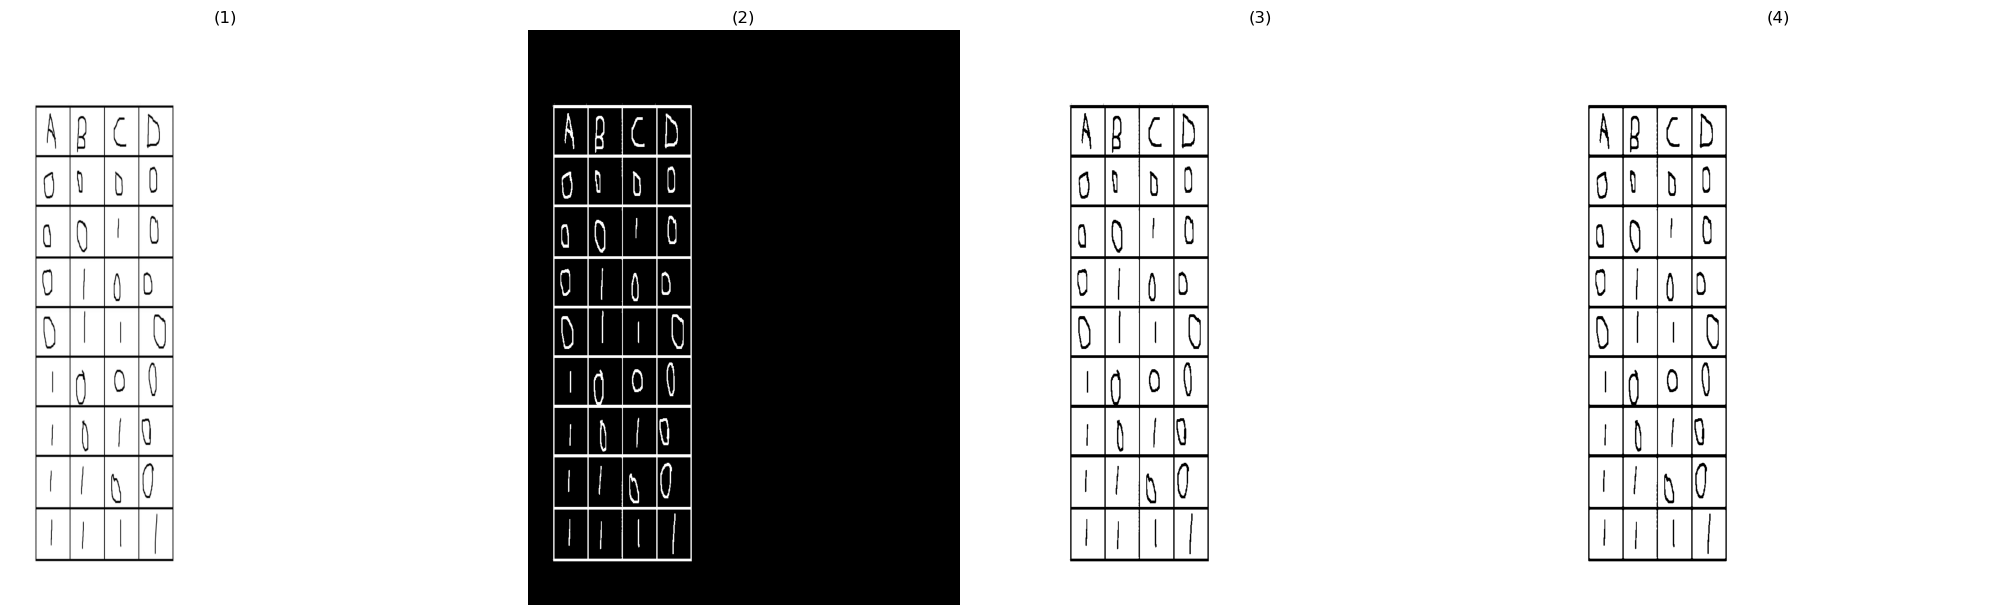

count rows 0


ZeroDivisionError: division by zero

In [36]:
image = cv2.imread("./test_images/table4.png")

# print(solve(img))

solve_expression(image, is_table=True)

# print(sol)



# show_images([numbers])

# for l in letters:
#     print(l)
# for l in numbers:
#     print(l)
# # numbers.shape



In [ ]:
%run table_detector.ipynb
# show_images([table_tany(numbers)])